Measuring of Urbanity
===================

In this notebook, we define a measure of urbanity for municipalities. First, we produce a composite score based the *Tranche d'aire urbaine* and *zonage en aire urbaine* in which the municipalities is located. Then, we take municipalities that belong to a larger *Tranches d'aires urbaines* of less than 100'000 inhabitants, and measure their distance to the nearest larger *Tranche d'aire urbaine*. Finally, we score these remaining municipalities according to a series of distance thresholds.

# 1 — General Commands

In [20]:
import requests
import pathlib
import urllib.request
import zipfile
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely

# 2 — Input data

## 2.1 — Geo data

### 2.1.1. — France municipalities

First, we input municipal borders in metropolitan France from *data.gouv.fr*.

In [15]:
""" Metropolitan France municipal geographical boundaries
    Dataset name: Communes France métropole 
    Data provider: data.gouv.fr
    Location (permalink): https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c
"""
url = 'https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c'
communes = gpd.read_file(url)
communes = communes.to_crs('epsg:2154')
communes.head()

,gml_id,CODE,LIBELLE,geometry
0,COMMUNE.01001,01001,L'ABERGEMENT-CLEMENCIAT,"MULTIPOLYGON (((851129.600 6563369.200, 851107..."
1,COMMUNE.01002,01002,L'ABERGEMENT-DE-VAREY,"MULTIPOLYGON (((888109.700 6545455.900, 888077..."
2,COMMUNE.01004,01004,AMBERIEU-EN-BUGEY,"MULTIPOLYGON (((886593.000 6540886.000, 886567..."
3,COMMUNE.01005,01005,AMBERIEUX-EN-DOMBES,"MULTIPOLYGON (((850413.200 6544061.000, 850356..."
4,COMMUNE.01006,01006,AMBLEON,"MULTIPOLYGON (((899820.100 6520340.200, 900065..."


To check if the geodata is coherent with what we want, and to verify the projection, we plot the geometries. 

In [ ]:
""" Plot France municipal geographical boundaries """
communes.plot()

### 2.1.2 France territory

In [162]:
""" Metropolitan France geographical boundaries
    Dataset name: France 
    Data provider: ArcGis Hub
    Location (permalink): https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson
"""
url = 'https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson'
france = gpd.read_file(url)
france = france.to_crs('epsg:2154')

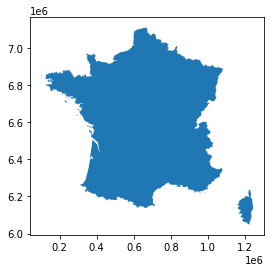

In [163]:
france.plot()

### 2.1.3 France cartograms

In [5]:
"""//
zipfile = '../data/maitre-map-cartogra_fr_muncipalities.zip'
municipalities_carto = gpd.read_file('zip://'+f+'!cartogram-communes.shp')
municipalities_carto.head()
//"""

"//\nzipfile = '../data/maitre-map-cartogra_fr_muncipalities.zip'\nmunicipalities_carto = gpd.read_file('zip://'+f+'!cartogram-communes.shp')\nmunicipalities_carto.head()\n//"

In [6]:
"""// municipalities_carto['area'] = municipalities_carto.area //"""

"// municipalities_carto['area'] = municipalities_carto.area //"

## 2.2 — Urban Areas

Second, we input data from INSEE about urban areas.

> Une aire urbaine ou "grande aire urbaine" est un ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle urbain (unité urbaine) de plus de 10 000 emplois, et par des communes rurales ou unités urbaines (couronne périurbaine) dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Le zonage en aires urbaines 2010 distingue également :

> * les "moyennes aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 5 000 à 10 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.
> * les "petites aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 1 500 à 5 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Les aires urbaines, datées de 2010, ont été établies en référence à la population connue au recensement de 2008.

Source: INSEE. *Base des aires urbaines*. Online: https://www.insee.fr/fr/information/2115011. 

### 2.2.1 — Input *Tranches d'aires urbaines*

INSEE ranks *Tranches d'aires urbaines* into 11 levels: 

* 00: Commune hors aire urbaine
* 01: Commune appartenant à une aire urbaine de moins de 15 000 habitants
* 02: Commune appartenant à une aire urbaine de 15 000 à 19 999 habitants
* 03: Commune appartenant à une aire urbaine de 20 000 à 24 999 habitants
* 04: Commune appartenant à une aire urbaine de 25 000 à 34 999 habitants
* 05: Commune appartenant à une aire urbaine de 35 000 à 49 999 habitants
* 06: Commune appartenant à une aire urbaine de 50 000 à 99 999 habitants
* 07: Commune appartenant à une aire urbaine de 100 000 à 199 999 habitants
* 08: Commune appartenant à une aire urbaine de 200 000 à 499 999 habitants
* 09: Commune appartenant à une aire urbaine de 500 000 à 9 999 999 habitants
* 10: Commune appartenant à l'aire urbaine de Paris 

We use two tables (sheets) from the file. We first input the list of  from an INSEE spreedsheet. In the table, we find four variable:

* **AU2010**: INSEE code of the *aire urbaine* as defined in 2010;
* **LIBAU2010**: label of this *aire urbaine*;
* **TAU2017**: *Tranche d'aire urbaine* as defined in 2017; and 
* **NB_COM**: number of municipalities included in the *aire urbaine*.

In [7]:
""" List Urban Areas
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Information: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
urban_areas = pd.read_excel(f, sheet_name='AU2010', header=5)
urban_areas.head()

,AU2010,LIBAU2010,TAU2017,NB_COM
0,000,Communes isolées hors influence des pôles,0,7006
1,001,Paris,10,1751
2,002,Lyon,9,498
3,003,Marseille - Aix-en-Provence,9,90
4,004,Toulouse,9,452


From this table, we look how many *Tranches d'aires urbaines* exist, how many *aires urbaines* exist, and how many municipalities belong to an *Aire urbaine*.

In [8]:
""" Number of geographical units """
pd.DataFrame.from_dict({"Urban areas":urban_areas.shape[0],
"Tranches d'aire urbaine":len(urban_areas['TAU2017'].unique()),
"Municipalities":urban_areas['NB_COM'].sum()}, orient='index', columns=['Count'])

,Count
Urban areas,793
Tranches d'aire urbaine,11
Municipalities,34968


We also look at how many municipalities are situated in each urabn area rank. This gives us an idea of the importance of each rank in terms of area.

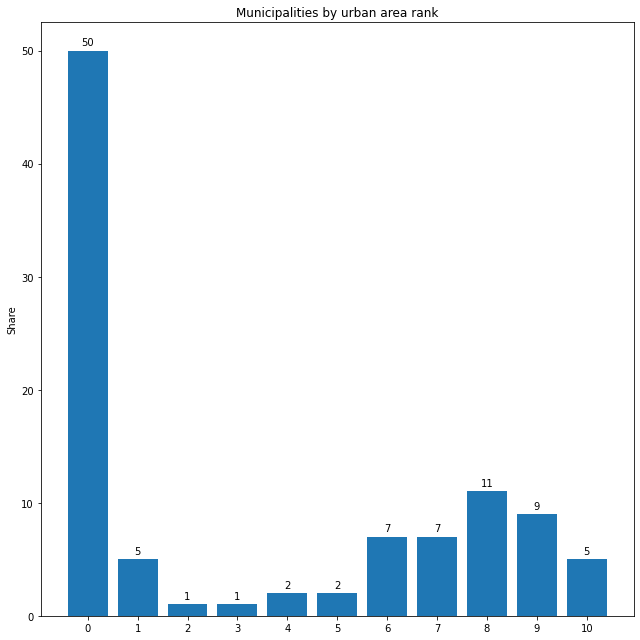

In [9]:
""" Share of municipalities by Tranche d'aire urbaine """
data = pd.DataFrame(urban_areas.groupby('TAU2017')['NB_COM'].sum() / urban_areas['NB_COM'].sum())

# Convert values to percentage integers
data = data.apply(lambda x: round(x, 2)*100)
data['NB_COM'] = data['NB_COM'].astype(int)

# Plot share of municipalities
labels = [str(x) for x in data.index]
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(9,9))
rects1 = ax.bar(x, data.values.ravel(), width, label='Share municipalities')

ax.set_ylabel('Share')
ax.set_title("Municipalities by urban area rank")
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

From this bar plot, we see that most municipalities are outside an urban area (49.67%). Contrary to what could be expected, the share of municipalities in each *Tranche d'aire urbaine* does not follow a *Zipf Law* distribution.

### 2.2.2 — Input *Zonage en aires urbaines*

Second, we input a list of all municipalities and their corresponding classification. In this table, we find five additional variables:

* **CODGEO**: INSEE code of the municipality;
* **LIBGEO**: Name of the municipality;
* **CATAU2010**: INSEE code of the *zone en aire urbaine* as defined in 2010;
* **DEP**: INSEE code of the department in which the municipality is located;
* **REG**: INSEE code of the region in which the municipality is located.

In [10]:
""" List Urban Areas Communes
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Location: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
ua_communes = pd.read_excel(f, sheet_name='Composition_communale', header=5)
ua_communes.head()

,CODGEO,LIBGEO,AU2010,LIBAU2010,CATAEU2010,DEP,REG
0,01001,L'Abergement-Clémenciat,997,Multipolarisé des grands pôles,120,01,84
1,01002,L'Abergement-de-Varey,002,Lyon,112,01,84
2,01004,Ambérieu-en-Bugey,002,Lyon,112,01,84
3,01005,Ambérieux-en-Dombes,002,Lyon,112,01,84
4,01006,Ambléon,998,Autre multipolarisé,300,01,84


In this data, labels for the *Zonage en aire urbaine* (CATAEU2010) are:
* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

Just like we did for urban area ranks, we look at how many municipalities exist in each urabn area zones.

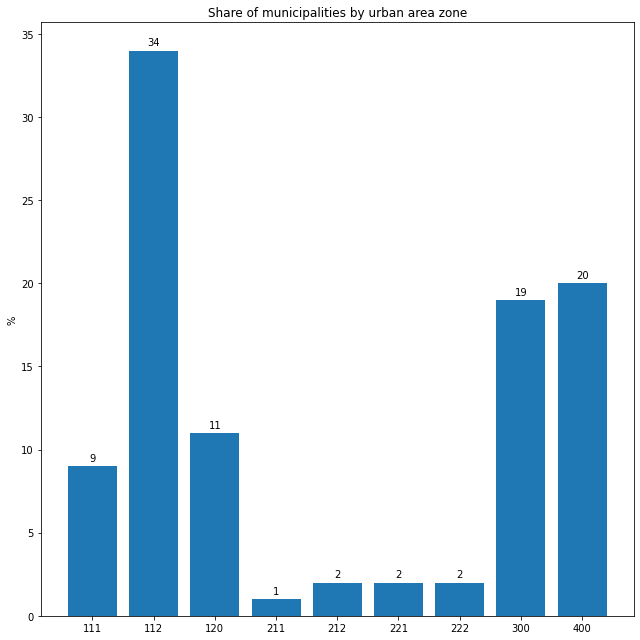

In [11]:
data = ua_communes.groupby('CATAEU2010')['CODGEO'].count() / ua_communes.shape[0]

# Convert values to percentage integers
data = data.apply(lambda x: int(round(x, 2)*100))

# Plot share of municipalities
labels = [str(x) for x in data.index]
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(9,9))
rects1 = ax.bar(x, data.values.ravel(), width, label='Share municipalities')

ax.set_ylabel('%')
ax.set_title("Share of municipalities by urban area zone")
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

### 2.2.3 — Mapping urban area ranks and zones
Using the data we have input, we visualize the geographical distribution of the urban area rank unto a map.

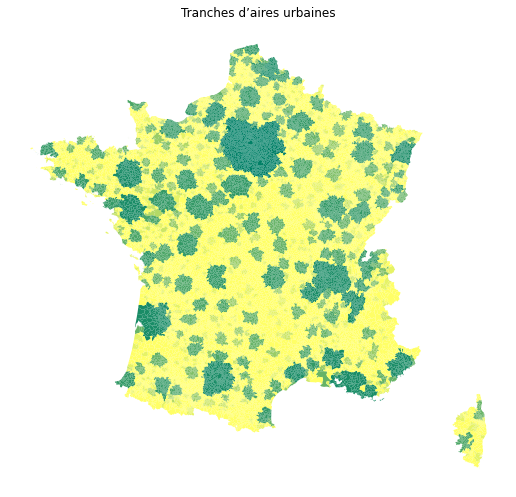

In [16]:
""" Map INSEE's Tranches d'aires urbaines """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
# Create a new variable for TAU2017 by replacing AU2010 through dict
data['TAU2017'] = data['AU2010'].replace(urban_areas.set_index('AU2010')['TAU2017'].to_dict())

data.plot(ax=ax, column='TAU2017', cmap='summer_r')
plt.title('Tranches d’aires urbaines')
ax.axis('off')

plt.show()

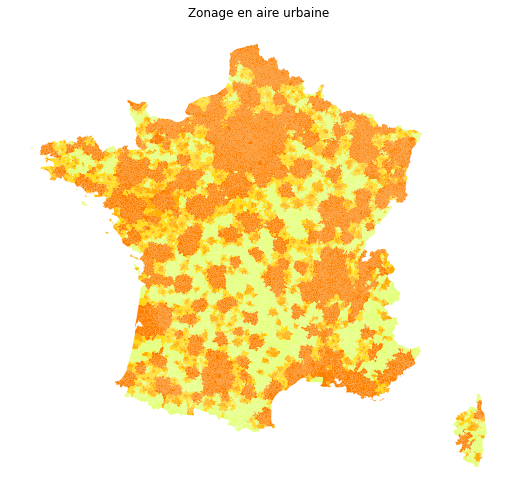

In [17]:
""" Map INSEE's 'Zonage en aires urbaines' """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
data.plot(ax=ax, column='CATAEU2010', cmap='Wistia_r')
plt.title('Zonage en aire urbaine')
ax.axis('off')

plt.show()

The maps above show the *Tranches d'aires urbaines* and the *Zonage en aire urbaine*. The former is a categorical variable with 793 values, while the later is a ordinal variable with 9 values.

## 3 — Measure distance between municipalities and urban area ranks (*tranches d'aires urbaines*)

To measure the distance between every municipality and the nearest urban area rank, we split municipalities in two subsets: those within a given urban area rank and those outside. For example, if we set the threshold to 100'000 inhabitants, we split municipalities that belong to an urban area rank of 100'000 and more, and those that do not.

In [217]:
""" Select municipalities within a 100'000 urban area rank or above """
idx = urban_areas[urban_areas['TAU2017'].isin([7,8,9,10])]['AU2010'].values
in_ua_muni_idx = ua_communes.set_index('AU2010').loc[idx]['CODGEO'].values
in_ua_muni_geo = communes.set_index('CODE').reindex(in_ua_muni_idx).dropna().geometry.values
large_urban_areas = shapely.geometry.MultiPolygon([i for sl in in_ua_muni_geo for i in sl])

idx = urban_areas[urban_areas['TAU2017'].isin([0,1,2,3,4,5,6])]['AU2010'].values
out_ua_muni_idx = ua_communes.set_index('AU2010').loc[idx]['CODGEO'].values
out_ua_muni_geo = communes.set_index('CODE').reindex(out_ua_muni_idx).dropna().geometry

In [23]:
""" Compute distance betwen out municipalities and nearest urban area"""
import os.path
from os import path
# Check first if the data is available locally
f = '../data/koseki-data-distance_to_urban_area_7to10.csv'
if path.exists(f):
    distances = pd.read_csv(f)
else:
    distances = out_ua_muni_geo.apply(lambda x: x.distance(large_urban_areas))
    
distances.head()

,CODE,geometry
0,01079,10249.867063
1,01081,1742.371020
2,01187,10230.570720
3,01210,0.000000
4,01247,0.000000


In [24]:
""" Rename variable """
distances.name = 'distance'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff319d9e610>]],
      dtype=object)

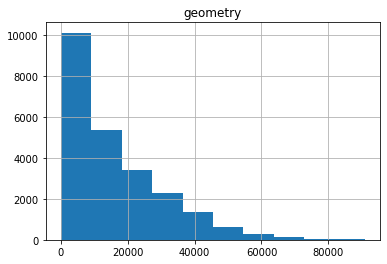

In [25]:
""" Plot distance data """
distances.hist()

In [27]:
""" Output distance data to csv file """
if path.exists(f):
    pass
else:
    distances.to_csv('../data/koseki-data-distance_to_urban_area_7to10.csv')

(41859.01937713251, 1299840.5928409076, 5993068.262450507, 7163751.301226321)

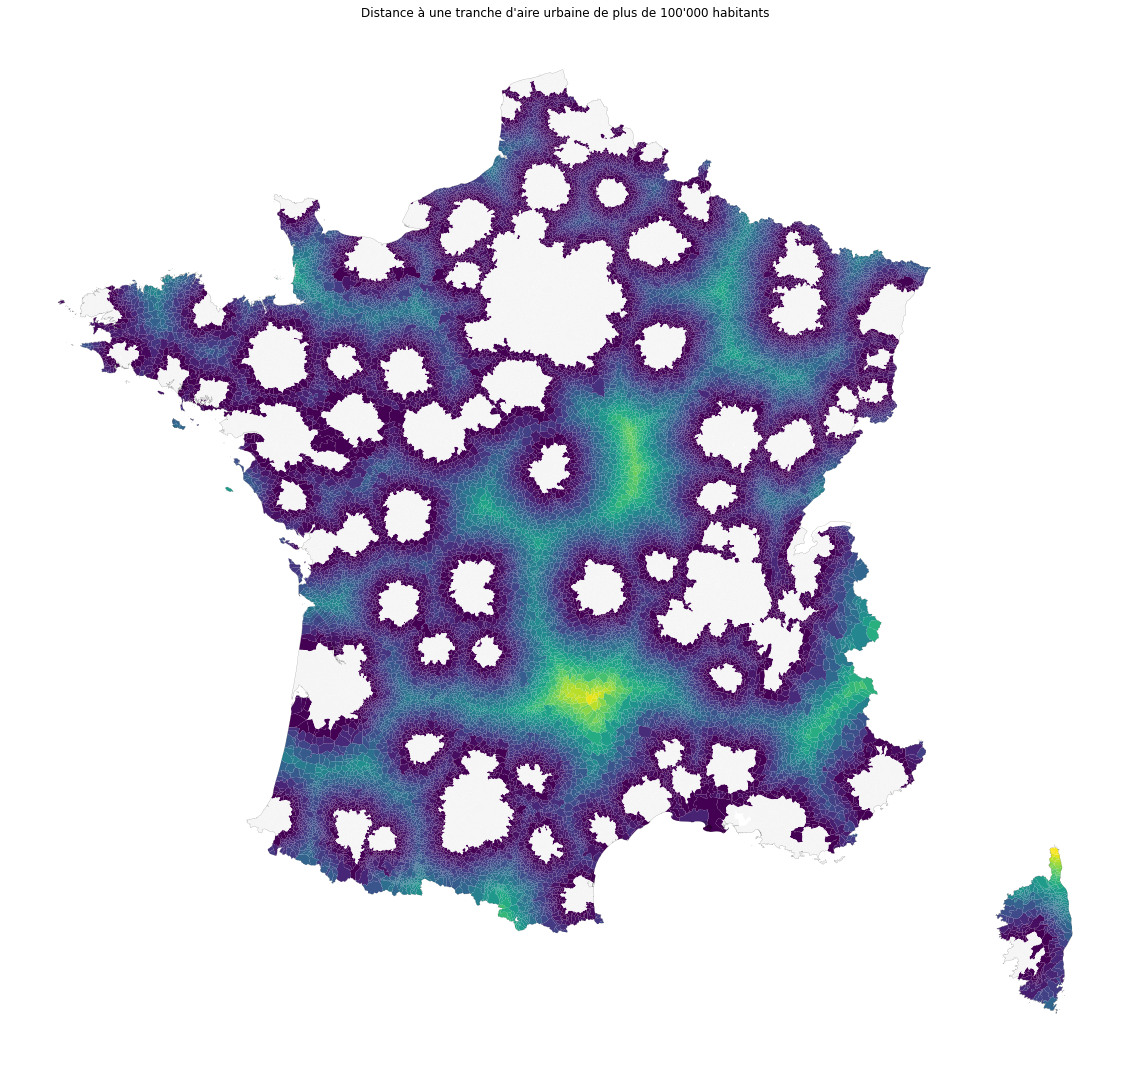

In [152]:
""" Plot map of distance to urban area above 100 k inhabitants """
data = communes.set_index('CODE').join(distances)

fig, ax = plt.subplots(figsize=(20,20))

data.plot(ax=ax, column='distance', cmap='viridis')
# Map urban areas
communes.set_index('CODE').reindex(in_idx).dropna().plot(ax=ax, color='whitesmoke')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1)

plt.title("Distance Euclidienne à une aire urbaine de plus de 100'000 habitants")
ax.axis('off')

# 4 — Urbanity index
Here, we attribute a measure of urbanity for each municipality based on the following score attribution table.
To compute the table's score, we proceed in four steps:
1. Score municipalities according to the size of their urban areas;
2. Score municipalities according to the urban area zoning;
3. Score municipalities outside of urban areas;
4. Score municipalities according to their distance to urban areas of more than 100k inhabitants.

## 4.1 — Set up
Here, we begin by setting up variables and data to properly score municipalities.
First, we split municipalities that are inside or outside of an urban area. To do so, we use the **AU2010** variable, in which municipalities outside of an urban area correspond to the values:
* 000 – *Communes isolées hors influence des pôles*
* 997 – *Multipolarisées des grands pôles*
* 998 – *Autre multipolarisées*

In [336]:
""" Split municipalities in and out of urban areas """
# Municipality urban score series for municipalities outside of an urban area
out_ua_muni_idx = list(ua_communes[ua_communes['AU2010'].isin(['000', '997', '998'])]['CODGEO'])
out_ua_muni_score = pd.DataFrame(data=0, index=list(out_ua_muni_idx), columns=['urban_index'])

# Municipality urban score series for municipalities inside of an urban area
in_ua_muni_idx = list(ua_communes[~ua_communes['AU2010'].isin(['000', '997', '998'])]['CODGEO'])
in_ua_muni_score = pd.DataFrame(data=0, index=list(in_ua_muni_idx), columns=['urban_index'])

## 4.2 — Score municipalities by urban area size

To attribute scores based on the population size of urban areas, we input municipal population data from INSEE.

In [29]:
""" Population by urban area
    Dataset name: POP6 – Population de 15 ans ou plus par sexe, âge et catégorie socioprofessionnelle
    Data provider: INSEE.fr
    Data location: https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip
    Information: https://www.insee.fr/fr/statistiques/4171341?sommaire=4171351#consulter
"""
url = 'https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip'
with urllib.request.urlopen(url) as r:
    muni_pop = pd.read_csv(io.BytesIO(r.read()),
                           compression='zip',
                           sep=';',
                           header=0,
                           dtype=str,
                           encoding='latin-1')
muni_pop.head()

,NIVGEO,CODGEO,LIBGEO,CS1_8,AGEQ65,SEXE,NB
5160144,COM,75056,Paris,1,015,1,0
5160145,COM,75056,Paris,1,015,2,0
5160146,COM,75056,Paris,1,020,1,0
5160147,COM,75056,Paris,1,020,2,8.4356608472
5160148,COM,75056,Paris,1,025,1,7.4364152917
...,...,...,...,...,...,...,...
5160315,COM,75056,Paris,8,055,2,9509.7479884
5160316,COM,75056,Paris,8,060,1,3497.3080272
5160317,COM,75056,Paris,8,060,2,8255.5914612
5160318,COM,75056,Paris,8,065,1,3387.9026339


The population data splits the number of inhabitants according to three variables: socioprofessional category (CS1_8), age group (AGEQ65) and gender (SEXE). To get a net population by municipality, we sum corresponding entries.

In [41]:
""" Sum number of people (NB) by municipality (CODGEO) """
# convert NB to float
muni_pop['NB'] = muni_pop['NB'].astype(float)
muni_pop_sum = muni_pop.groupby('CODGEO')['NB'].sum()
muni_pop_sum.name = 'POP'

In [337]:
""" Attribute points according to the size of the urban area rank 
    
    Note: This attributes scores to “multipolarized” (997 and 998) and ”isolated” (000) municipalities.
    We shall replace these scores later on.
"""
thresholds = [0, 20000, 100000, 500000, 1000000, 3000000, 15000000] 
ranges = list(zip(thresholds, thresholds[1:]))
scores = dict([(i+1,j) for i, j in (zip(range(len(ranges)), ranges))]) # To replace by file 
for score in scores:
    thresholds = scores[score]
    # Municipalities that belong to a urban area with given population range
    ua_idx = ua_pop[ua_pop.between(thresholds[0], thresholds[1], inclusive=True)].index
    # select municpalities corresponding to the urban area index
    muni_idx = list(ua_communes.set_index('AU2010').loc[ua_idx]['CODGEO'])
    # filter out idx to avoid having idx from muni outside of urban areas
    muni_idx = [x for x in muni_idx if x in in_ua_muni_idx]
    in_ua_muni_score.loc[muni_idx] = in_ua_muni_score.loc[muni_idx]+score
in_ua_muni_score.head()

,urban_index
01002,5
01004,5
01005,5
01007,5
01008,5


## 4.3 — Score municipalities by urban area zoning

Next, we add points according to the municipality's location wihtin an urban area. For this, we rely on the INSEE classification of  municipalities in “Zonage en aire urbaine,” which describres three types of zones: central, first crown and multipolarized. In the data, this corresponds to the “CATAEU2010" variable, which takes up 9 values:

* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

Given the classification of the INSEE, no municipalities located in an urban area belongs to the following categories:
* 120;
* 300;
* 400.

These municipalities exclusively locate outside of urban areas as classified by INSEE.

In [338]:
""" Add points according to urban area zoning """
# score dictionnary based on the CATAEU2010 values --> This shall be transfered to a file
scores = {111:1, 112:2, 211:1, 212:2, 221:1, 222:2, 120:99, 300:99, 400:99} # 99 values should not appear in index
for zone in scores:
    score = scores[zone]
    muni_idx = list(ua_communes.set_index('CATAEU2010').loc[zone]['CODGEO'])
    # filter out idx to avoid having idx from muni outside of urban areas
    muni_idx = [x for x in muni_idx if x in in_ua_muni_idx]
in_ua_muni_score.loc[muni_idx] = in_ua_muni_score.loc[muni_idx]+score
in_ua_muni_score.head()

,urban_index
01002,5
01004,5
01005,5
01007,5
01008,5


## 4.3 — Score municipalities outside of urban areas
We classify municipalties that locate outside of an urban area in two categories: multipolarized, and isolated. To do so, we rely on INSEE CATEAU2010 classification, and attribute scores to categories 120 and 300 on the one hand, and category 400 on the other hand.

In [339]:
""" Attribute points for communes outside of urban areas """
scores = {120:9, 300:9, 400:10} # 99 values should not appear in index
for zone in scores:
    score = scores[zone]
    idx = ua_communes[ua_communes['CATAEU2010']==zone].set_index('CODGEO').index
    out_ua_muni_score.loc[idx] = out_ua_muni_score.loc[idx] + score
out_ua_muni_score.head()

9
9
10


,urban_index
01001,9
01006,9
01010,9
01012,9
01016,9


In [ ]:
""" Add points for distance to large urban area """



(41859.01937713248, 1299840.5928409076, 5993068.262450506, 7163751.30122632)

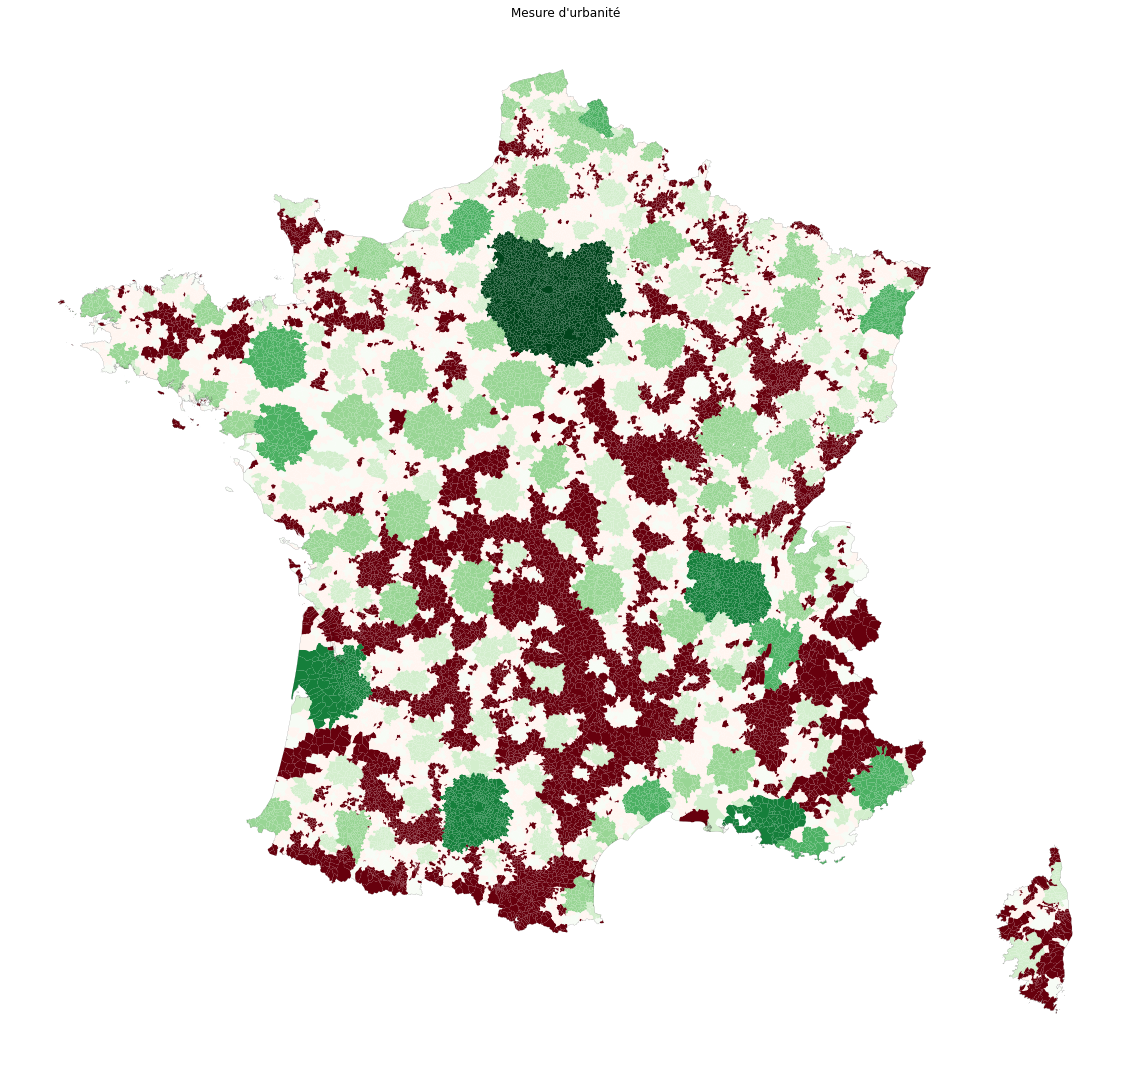

In [343]:
""" Plot map of distance to urban area above 100 k inhabitants """
in_data = communes.set_index('CODE').join(in_ua_muni_score).dropna(how='any', axis=0)
out_data = communes.set_index('CODE').join(out_ua_muni_score).dropna(how='any', axis=0)

fig, ax = plt.subplots(figsize=(20,20))

in_data.plot(ax=ax, column='urban_index', cmap='Greens')
out_data.plot(ax=ax, column='urban_index', cmap='Reds')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1)

plt.title("Mesure d'urbanité")
ax.axis('off')

In [294]:
""" Table of municipalities / population by gradient d'urabnité (taking the same table format than the score table )"""

" Table of municipalities / population by gradient d'urabnité (taking the same table format than the score table )"